In [263]:
import numpy as np
import matplotlib.pyplot as plt

In [283]:
def loadFile(filename):
    fr = open(filename)
    arrayOLines = fr.readlines()
    datasets = []
    labels = []
    for line in arrayOLines:
        listOfLine = line.strip().split('\t')
        length = len(listOfLine)
        datasets.append(listOfLine[:length - 1])
        labels.append(int(listOfLine[-1]))
        
       # tranfer the data format from 'String' to 'Float'
    n, p = np.shape(datasets)
    dataMat = np.zeros((n, p))
    for i in range(n):
        for j in range(p):
            dataMat[i][j] = float(datasets[i][j])
        
    dataMat = dataMat.T  # p×n: p means dimension, n means number
    dataMat = np.vstack((np.ones(len(dataMat[0])), dataMat))  # add a row of 1s for datasets for flexibility and generalization
    labels = np.array(labels)
    return dataMat, labels

def sigmoid(x):
    return 1 / (1 + np.exp(-np.maximum(x, -20)))  # for numerical stability
    #return 1 / (1 + np.exp(-x))

def gradDescentLogReg(datasets, labels):   
    beta = np.reshape(np.random.randn(len(datasets)), (-1, 1)) # Initialize weigths beta
    alpha = 0.001
    for ite in range(2000):
        predicts = sigmoid(beta.T.dot(datasets))
        gradient = datasets.dot((predicts - labels).T)
        betaNew = beta - alpha * gradient  # gradient descent
        beta = betaNew
    return beta

def sgdLogReg(datasets, labels): 
    beta = np.reshape(np.random.randn(len(datasets)), (-1, 1)) # Initialize weigths beta
    length = len(datasets.T)
    index = np.arange(length)
    np.random.shuffle(index)  # shuffle the data: stochastic
    for ite in range(1000):
        for i in index:
            alpha = 4 / (1 + i + ite) + 0.01
            predicts = sigmoid(beta.T.dot(datasets[:, i]))
            error = predicts.T - labels[i]
            error = np.reshape(error, (1, -1))
            gradient = np.reshape(datasets[:, i], (-1, 1)).dot(error)
            beta = beta - alpha * gradient 
    return beta

In [284]:
datasets, labels = loadFile('testSet.txt')

[[ 6.87617098]
 [ 0.69382417]
 [-0.96761445]]


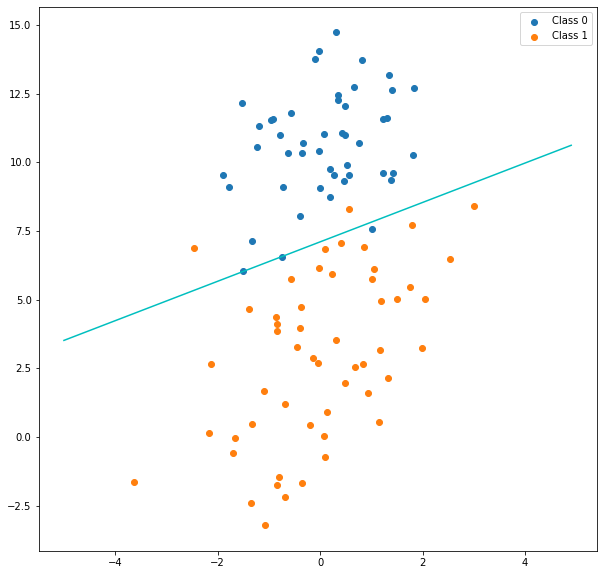

In [285]:
# plot the decision boundary w1*x1 + w2*x2 + w0 = 0 using gradient descent
beta = gradDescentLogReg(datasets, labels)
print(beta)
x1Seq = np.arange(-5, 5, 0.1)
x2 = - (beta[0] + beta[1] * x1Seq) / beta[2]
plt.scatter(datasets[1, labels==0], datasets[2, labels==0], label='Class 0')
plt.scatter(datasets[1, labels==1], datasets[2, labels==1], label='Class 1')
plt.plot(x1Seq, x2, color='c')
plt.legend(loc='best')
plt.rc('figure', figsize=(10, 10))


[[14.67451299]
 [ 1.23166395]
 [-2.02714663]]


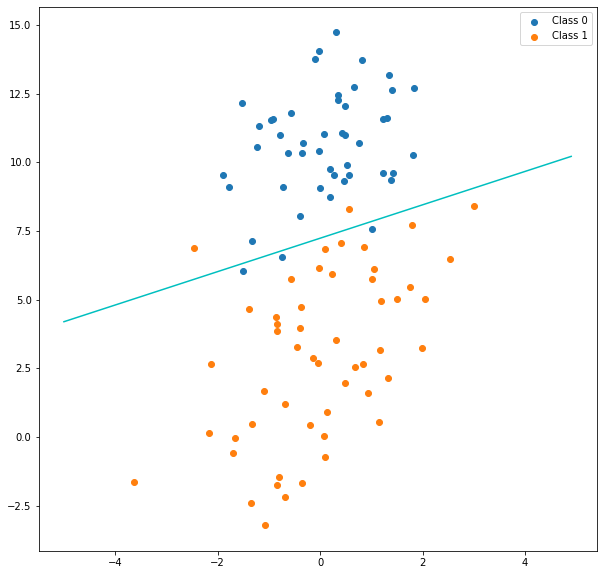

In [286]:
# plot the decision boundary w1*x1 + w2*x2 + w0 = 0 using gradient descent
beta = sgdLogReg(datasets, labels)
print(beta)
x1Seq = np.arange(-5, 5, 0.1)
x2 = - (beta[0] + beta[1] * x1Seq) / beta[2]
plt.scatter(datasets[1, labels==0], datasets[2, labels==0], label='Class 0')
plt.scatter(datasets[1, labels==1], datasets[2, labels==1], label='Class 1')
plt.plot(x1Seq, x2, color='c')
plt.legend(loc='best')
plt.rc('figure', figsize=(10, 10))

# Predicting Mortality from Sick Horses from Hernia Cases

In [221]:
def loadRawData(file):
    fr= open(file)
    arrayOfLines = fr.readlines()
    datasets = []
    labels = []
    for line in arrayOfLines:
        listOfLine = line.strip().split(' ')
        if len(listOfLine) < 28:  # if it exists an instance which is lack of label
            continue
        # ignore the 3.rd attribute "Hospital Number" since it is meaningless 
        reducedList = listOfLine[:2]
        reducedList.extend(listOfLine[3:len(listOfLine) - 1])
        datasets.append(reducedList)
        labels.append(listOfLine[-1])
    return datasets, labels

def transpose(lists):
    height, width = np.shape(lists)
    return [[lists[row][col] for row in range(0,height) ] for col in range(0,width) ]
    
# fill up default values:'?' with some values based on collaborative filtering Alg.
# For a default value '?' in a certain attribute A from an instance X,
# search all of other instances(a row data) whose attribute A is not empty, 
# com pute the similarity between those instances and instance X, pick several
# most similar instances based on Pearson corelation formular and use the 
# weighted average value of attribute A from those similar instances to fil up
# the value in attribute A from X
def findPairSets(datasets, dataIndex, defaultIndex):
    """
    find pair instances used for compare similarities
    datasets: whole raw datasets
    dataIndex, defaultIndex: the index of instance "dataIndex" whose
                             Nr."defaultIndex" attribute has a default value

    """
    wholeIndex = np.arange(len(datasets))
    differenceIndex = list(set(wholeIndex).difference(set([dataIndex])))
    diffDatasets = datasets[differenceIndex]
    pairSets = []
    pairIndex = []
    for index, instance in enumerate(diffDatasets):
        # find the instance whose Nr.'defaultIndex' is not default
        if instance[defaultIndex] != np.pi: # np.pi refers to default value
            pairSets.append(instance)
            pairIndex.append(index)
    return np.array(pairSets), np.array(pairIndex)

def pearsonSet(instance):
    featureSets = []
    markIndex = [] # mark the index of attributes with default value
    for i in range(len(instance)):
        if instance[i] != np.pi: # np.pi refers to default value
            featureSets.append(instance[i])
        else:
            markIndex.append(i)
    average = np.mean(featureSets)
    instance[markIndex] = 0
    pearsonInstance = instance - average
    pearsonInstance[markIndex] = 0
    return pearsonInstance

def pearsonSim(instance, pearsonInstance):
    pearsonInstance = pearsonSet(instance)
    pearsonPairSet = pearsonSet(pearsonInstance)
    similarity = pearsonInstance * pearsonPairSet / (np.sum(pearsonInstance**2) * np.sum(pearsonPairSet**2)*0.01)
    similarity = pearsonInstance * pearsonPairSet / (np.sum(pearsonInstance**2) * np.sum(pearsonPairSet**2) + 0.01)
    return similarity

def setToNumerical(datasetsRaw):
    """
    transfer each attribute value from string type to float type
    and mark the default value:'?' as np.pi for computing convienence.
    return: numerical sets replacing default values as np.pi
            and find their index
    """
    datasets = transpose(datasetsRaw)
    markIndex = []  # mark the index for all of default values
    for instance in datasets:
        index = []
        for i in range(len(instance)):
            if instance[i] != '?':
                instance[i] = float(instance[i])
            else:
                instance[i] = np.pi  # set '?' to a specific value np.pi for marking
                index.append(i)
        markIndex.append(index)
    numericalSets = np.array(datasets)
    markIndex = np.array(markIndex)
    return numericalSets, markIndex

def normSets(numericalSets, markIndex):
    """
    normalize all of entries in each attribute for further mean value computing.
    Notice that for the last two attributes/columns most of entries are zeros, 
    weignore normalizing these two attributes.
    """
    length = len(numericalSets[0])  
    maximum = np.zeros((len(numericalSets), 1)) # initialize the maximum for each feature
    minimum = np.zeros((len(numericalSets), 1))  # # initialize the minimum for each feature
    for i in range(len(numericalSets)):
        diffIndex = list(set(np.arange(length)).difference(set(markIndex[i])))
        feature = numericalSets[i]
        maximum[i] = np.max(feature[diffIndex])
        minimum[i] = np.min(feature[diffIndex])
    # normalize each feature
    normDatasets = (numericalSets - minimum) / (maximum - minimum)
    # set the defalt value back to np.pi
    for i, index in enumerate(markIndex):
        feature = normDatasets[i]
        feature[index] = np.pi
    return normDatasets.T

def fillDefault(datasetsRaw, threshold):
    numericalSets, markIndex = setToNumerical(datasetsRaw)
    normDatasets = normSets(numericalSets, markIndex)
    for index, instance in enumerate(normDatasets):
        for i in range(len(instance)):
            if instance[i] == np.pi:
                pairSets, pairIndex = findPairSets(normDatasets, index, i)
                similarity = []
                for pairinstance in pairSets:
                    similarity.append(pearsonSim(instance, pairinstance))
                # sort the similarities by descending order, which means find most 
                # similar instances 
                #print(len(similarity))
                sim = np.sort(similarity)[::-1] 
                sim = sim[:threshold]
                simIndex = np.argsort(similarity)[::-1]
                candidatesIndex = pairIndex[simIndex]
                candidatesIndex = candidatesIndex[:threshold]
                candidates = normDatasets[candidatesIndex]
                candidateValue = []
                for candidate in candidates:
                    candidateValue.append(candidate[i])
                instance[i] = np.sum(np.array(candidateValue) * sim) / np.sum(np.array(candidateValue))
    return normDatasets.T

In [226]:
threshold = 3
filenameTrain = 'horse-colic-train_raw.txt'
filenameTest = 'horse-colic-test_raw.txt'
datasetsRawTrain, labelsRawTrain = loadRawData(filenameTrain) # exsiting default value in entries
datasetsRawTest, labelsRawTest = loadRawData(filenameTest) # exsiting default value in entries
datasetsRawTrain = np.array(datasetsRawTrain)
datasetsRawTrain = list(datasetsRawTrain[:,:-2])
datasetsRawTest = np.array(datasetsRawTest)
datasetsRawTest = list(datasetsRawTest[:,:-2])
datasetsTrain = fillDefault(datasetsRawTrain, threshold)  # 24*300

In [227]:
testsets = transpose(datasetsRawTest)
markIndex = []  # mark the index for all of default values
for instance in testsets:
    for i in range(len(instance)):
        if instance[i] != '?':
            instance[i] = float(instance[i])
        else:
            instance[i] = 0  # set '?' to a specific value 0
testsets = np.array(testsets)

length = len(testsets[0])  
maximum = np.zeros((len(testsets), 1)) # initialize the maximum for each feature
minimum = np.zeros((len(testsets), 1))  # # initialize the minimum for each feature
for i, feature in enumerate(testsets):
    maximum[i] = np.max(feature)
    minimum[i] = np.min(feature)
# normalize each feature
datasetsTest = ((testsets - minimum) / (maximum - minimum)) # 24*68

In [228]:
for i in range(len(labelsRawTrain)):
    labelsRawTrain[i] = int(labelsRawTrain[i])
for i in range(len(labelsRawTest)):
    labelsRawTest[i] = int(labelsRawTest[i])

In [236]:
trainSets = np.vstack((np.ones(len(datasetsTrain[0])), datasetsTrain))
testSets = np.vstack((np.ones(len(datasetsTest[0])), datasetsTest))